# EDA

In [46]:
import os
import pandas as pd
import numpy as np
import constants as ct
from kaggletoxicity.utils import get_upper_case_prop, get_punctuation_prop, process_text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
from tqdm import tqdm
from mlxtend.frequent_patterns import apriori, association_rules


%matplotlib inline


pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
pd.options.display.width = 1000
pd.options.display.max_colwidth = 200

X_train = pd.read_hdf(ct.STORE_PATH, 'X_train')
Y_train = pd.read_hdf(ct.STORE_PATH, 'Y_train')
X_full = pd.read_hdf(ct.STORE_PATH, 'X_full')
flame_example = pd.read_hdf(ct.STORE_PATH, 'flame_example')

In [47]:
Y_train.sum().div(Y_train.shape[0] / 100).sort_values(ascending=False)

toxic            9.584448
obscene          5.294822
insult           4.936361
severe_toxic     0.999555
identity_hate    0.880486
threat           0.299553
dtype: float64

## Longitud de comentarios

In [55]:
# X_full.comment_text.map(lambda s:)
len_comments = X_full.comment_text.str.len()
len_comments.describe()

count    312735.000000
mean        379.773262
std         591.767791
min           1.000000
25%          87.000000
50%         193.000000
75%         414.000000
max        5000.000000
Name: comment_text, dtype: float64

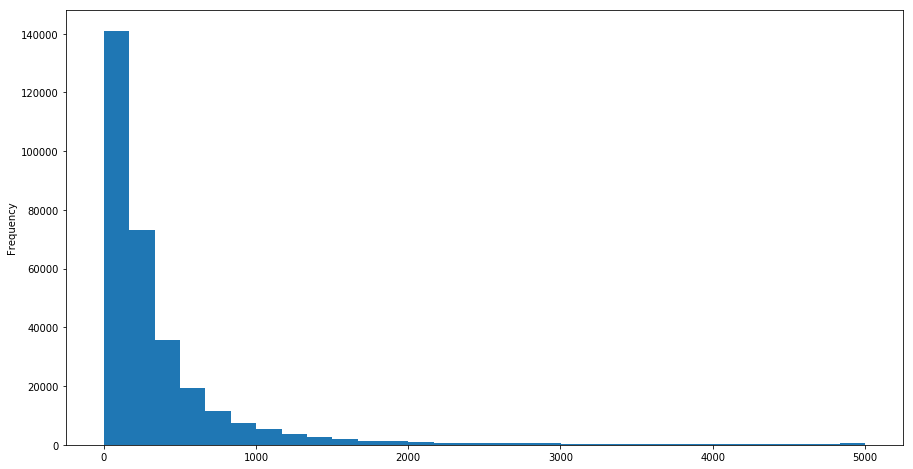

In [54]:
len_comments.plot(kind="hist", bins=30, figsize=(15, 8));

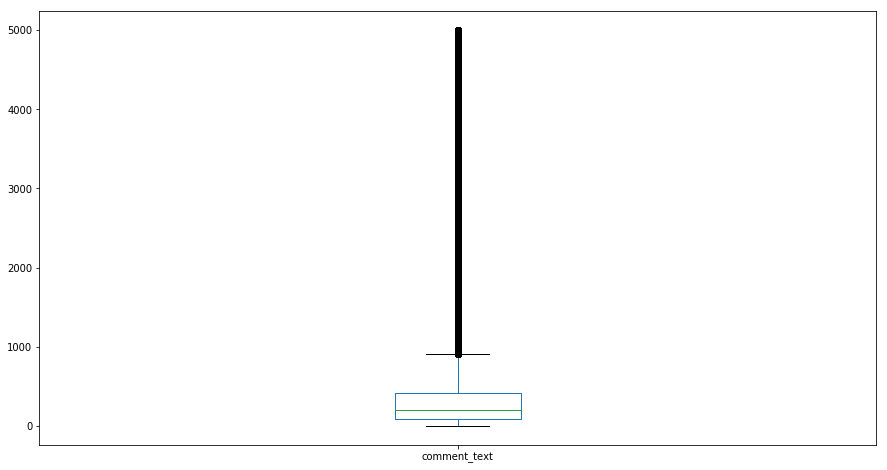

In [59]:
len_comments.plot(kind="box", figsize=(15, 8));

In [60]:
len_comments.quantile(np.linspace(0, 1, 21))

0.00       1.0
0.05      30.0
0.10      42.0
0.15      55.0
0.20      71.0
0.25      87.0
0.30     105.0
0.35     124.0
0.40     145.0
0.45     167.0
0.50     193.0
0.55     224.0
0.60     260.0
0.65     301.0
0.70     350.0
0.75     414.0
0.80     502.0
0.85     630.0
0.90     848.0
0.95    1314.0
1.00    5000.0
Name: comment_text, dtype: float64

In [61]:
X_train.comment_text.isnull().sum()

0

## Asociación entre etiquetas

In [10]:
implications = pd.DataFrame(np.nan, index=Y_train.columns, columns=Y_train.columns)

for col_ant in Y_train.columns:
    for col_con in Y_train.columns:
        
        selection_df = Y_train.loc[Y_train[col_ant] == 1]
        n_ant = selection_df.shape[0]
        n_con = selection_df[col_con].sum()
        implications.loc[col_ant, col_con] = n_con / n_ant
        
implications

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.104289,0.518242,0.029358,0.480188,0.085131
severe_toxic,1.000000,1.000000,0.951097,0.070219,0.859561,0.196238
obscene,0.938099,0.179548,1.000000,0.035626,0.728489,0.122145
threat,0.939331,0.234310,0.629707,1.000000,0.642259,0.205021
insult,0.932335,0.174051,0.781389,0.038974,1.000000,0.147264
identity_hate,0.926690,0.222776,0.734520,0.069751,0.825623,1.000000


In [18]:
frequent_itemsets = apriori(Y_train, min_support=1e-6, use_colnames=True)

In [19]:
frequent_itemsets.head(20)

,support,itemsets
0,0.095844,[toxic]
1,0.009996,[severe_toxic]
2,0.052948,[obscene]
3,0.002996,[threat]
4,0.049364,[insult]
5,0.008805,[identity_hate]
6,0.009996,"[toxic, severe_toxic]"
7,0.049671,"[toxic, obscene]"
8,0.002814,"[toxic, threat]"
9,0.046023,"[toxic, insult]"


In [20]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

In [28]:
rules['n_elements'] = rules.support.mul(Y_train.shape[0])
rules.sort_values(by=['confidence', 'n_elements'], ascending=[False, False], inplace=True)

In [29]:
Y_train.shape

(159571, 6)

In [31]:
rules.head(50)

,antecedants,consequents,support,confidence,lift,n_elements
263,(severe_toxic),(toxic),0.009996,1.000000,10.433569,1595.0
50,"(severe_toxic, obscene)",(toxic),0.009507,1.000000,10.433569,1517.0
265,"(severe_toxic, insult)",(toxic),0.008592,1.000000,10.433569,1371.0
99,"(severe_toxic, insult, obscene)",(toxic),0.008454,1.000000,10.433569,1349.0
114,"(identity_hate, severe_toxic)",(toxic),0.001962,1.000000,10.433569,313.0
127,"(identity_hate, severe_toxic, insult)",(toxic),0.001899,1.000000,10.433569,303.0
168,"(identity_hate, severe_toxic, obscene)",(toxic),0.001893,1.000000,10.433569,302.0
81,"(identity_hate, severe_toxic, insult, obscene)",(toxic),0.001855,1.000000,10.433569,296.0
137,"(severe_toxic, threat)",(toxic),0.000702,1.000000,10.433569,112.0
210,"(obscene, severe_toxic, threat)",(toxic),0.000620,1.000000,10.433569,99.0


In [5]:
for text in flame_example.comment_text.head(50):
    
    print('*' * 120)
    print(text)
    print('\n')
    print(process_text(text, stem_words=False, remove_stop_words=False))
    print('-' * 120)
    print('\n \n')

************************************************************************************************************************
Nitpicking
If someone is complaining about something stupid, just ignore them. -


nitpicking if someone is complaining about something stupid just ignore them  
------------------------------------------------------------------------------------------------------------------------

 

************************************************************************************************************************
What the fuck is wrong with you? You say I am a fucking vandal and I havn't done anything. Your bot is fucked up.


what the fuck is wrong with you you say i am a fucking vandal and i have not done anything your bot is fucked up 
------------------------------------------------------------------------------------------------------------------------

 

********************************************************************************************************************

## Procesamos

In [ ]:
X_full_proc = X_full.copy()

for row_index in tqdm(X_full_proc.index):
    X_full_proc.loc[row_index, 'comment_text'] = process_text(X_full_proc.loc[row_index, 'comment_text'])
# X_full_proc.comment_text = X_full_proc.comment_text.map(process_text)

In [ ]:
# corpus_text = reduce(sum, X_full.comment_text.values)
X_full.comment_text.values[:2]

In [ ]:
len(corpus_text)

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_1 + texts_2 + test_texts_1 + test_texts_2)

sequences_1 = tokenizer.texts_to_sequences(texts_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH) #cambia a padding por la izquierda